In [1]:
import json
import numpy as np
import time
import os
import pandas as pd
from FunUtil import memoize
import matplotlib.pyplot as plt

<h2 align="left"><font color='red'> IV.4: 8-Puzzle Problem </font></a></h2>  

![](https://ece.uwaterloo.ca/~dwharder/aads/Algorithms/N_puzzles/images/puz3.png)

&emsp; &emsp; **<font color='blue'> Start state</front>**        &emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;      **<font color='green'> Goal state</front>**

<font color='black'> </front>
The 8-puzzle is a sliding puzzle that consists of a frame of numbered square tiles from 1 to 8 in random order with one tile missing. The objective of the puzzle is to place the tiles in order by making sliding moves that use the empty space.

A sliding tile puzzle where you can swap the blank with an adjacent piece, trying to reach a goal configuration. The cells are numbered 0 to 8, starting at the top left and going row by row left to right. The pieces are numebred 1 to 8, with 0 representing the blank. 

Note that this puzzle also exists in other sizes, for example 3-puzzle (2x2), 15-puzzle (4x4), 24-puzzle (5x5), etc.

 1. <font color='darkred'>Formulate the 8-puzzle problem (implement a class EightPuzzle)</front>
 2. <font color='darkred'>Implement uniform cost search for this example</front>
 3. <font color='darkred'>Implement two heuristics for the problem (misplaced tiles and manhattan distance)</front>
 4. <font color='darkred'>Implement a greedy search that reaches the goal state</front>
 5. <font color='darkred'>Implement A* search considering two different heuristics</front>
 6. <font color='darkred'>Compare the results obtained from the different search algorithms that were performed.</front>

<font color='darkred'>Comment on all aspects of your implementation.
</front>

# 1. Formulate the 8-puzzle problem (implement a class EightPuzzle)
For this problem, to respond to a lot of data to resolve a case of eightpuzzle, I will generate all the tree which will start by the answer state.

In this tree the root will be the state already explored. To save all the tree I will save it in tree.ndjson and two other folders.

## A. External function of class EightPuzzle

In [2]:
def arrayToMat(array):
    """
    Create the matrix 3*3 of the input array of size 9
    """
    mat = np.zeros(shape=(3, 3))
    k = 3
    for i in range(3):
        mat[i] = array[k-3:k]
        k+=3
    return mat
def matToArray(mat):
    """
    Create the array of size 9 from an input matrix of shape 3*3
    """
    arr = []
    for i in range(3):
        for j in range(3):
            arr.append(int(mat[i][j]))
    return arr

## B. Class EightPuzzle

In [3]:
class EightPuzzle:
    """ 
    EightPuzzle works like a node. But in a first part when we will generate the tree we will not use the parent parameter.
    But id and labelVal like a reference of ancestors of each puzzle.
    We will use search method, we will use parent to get the solution path.
    """
    def __init__(self, state_, id=1, labelVal=1,valMoove=None, depth=0, parent=None):
        """
        state_ can be an array of a matrix that we will get state = matrix(state_) and state_arr = array(state_).
        id = 1 by default (root's id) or (parent.id-1)*4 + labelVal.
        valMoove = it is the number which was moved from the parent EightPuzzle to get the current puzzle.
        depth = 0 by default or parent.depth + 1.
        parent=None or parent puzzle of the current puzzle.
        """
        try:
            self.state = arrayToMat(state_)
        except:
            self.state = state_.copy()
        try:
            self.state_arr = matToArray(state_)
        except:
            self.state_arr = state_
            
        self.id = id
        #self solve is True if state_arr is equal to the goal
        self.solve = self.state_arr == [1,2,3,4,5,6,7,8,0]
        self.labelVal = labelVal
        self.valMoove = valMoove
        self.depth = depth
        self.parent = parent
        
   
    def __repr__(self):
        """
        return a string like this:
        if it is a roots:
            start:
            the matrix state
        else:
            what was the moove + the value which was moove:
            the matrix state
        """
        labels = ['start :', 'move up', 'move down', 'move left', 'move right']
        if self.labelVal != 1:
            label = str(labels[self.labelVal-1]) + ' ' + str(self.valMoove) + ' :'
        else:
            label = 'start :'
        return "{}\n{}\n".format(label, self.state)
        
    def toDict(self):
        """
        to put a puzzle in a ndjson file
        and format we have to convert to a dict
        Like said previously, in .ndjson file we don't care of parent
        """
        return {
            'id' : self.id,
            'labelVal' : self.labelVal,
            'valMoove' : self.valMoove,
            'state_arr' : self.state_arr,
            'depth' : self.depth,
        }

    def generateChild(self):
        """
        return a list of all possible children of the puzzle
        Child depend of the position of the zero in the matrix
        """
        mat = self.state.copy()
        index = np.where(mat == 0)
        i = index[0][0]
        j = index[1][0]
        Child = []
        #up
        if i <= 1:
            mat[i,j] = mat[i+1,j]
            mat[i+1,j] = 0
            id = (self.id-1)*4 + 2
            labelVal = 2
            valMoove = int(mat[i,j])
            Child.append(EightPuzzle(mat,id,labelVal,valMoove,self.depth+1))
            mat = self.state.copy()
        #down
        if i >= 1:
            mat[i,j] = mat[i-1,j]
            mat[i-1,j] = 0
            id = (self.id-1)*4 + 3
            labelVal = 3
            valMoove = int(mat[i,j])
            Child.append(EightPuzzle(mat,id,labelVal,valMoove,self.depth+1))
            mat = self.state.copy()

        #left
        if j <= 1:
            mat[i,j] = mat[i,j+1]
            mat[i,j+1] = 0
            id = (self.id-1)*4 + 4
            labelVal = 4
            valMoove = int(mat[i,j])
            Child.append(EightPuzzle(mat,id,labelVal,valMoove,self.depth+1))
            mat = self.state.copy()
        #right
        if j >= 1:
            mat[i,j] = mat[i,j-1]
            mat[i,j-1] = 0
            id = (self.id-1)*4 + 5
            labelVal = 5
            valMoove = int(mat[i,j])
            Child.append(EightPuzzle(mat,id,labelVal,valMoove,self.depth+1))
            mat = self.state.copy()
        return Child

    def getParentId(self):
        """ simple equation : id = (parent.id-1)*4 + labelVal 
        """
        return int((self.id - self.labelVal)/4 + 1)

## C. Json Function

In [4]:
currentPath = os.getcwd()
#explore files we will be use to generate the tree but also in all search algorithms
explorePath = os.path.join(currentPath,r'data\explore')
"""
stack files will simulate a real stack 
each stack file will contains a maximum of maxLinesStack value
"""
stackPath = os.path.join(currentPath,r'data\stack')
maxLinesStack = 1000 #1000 lines per stack file
"""
All the tree will be in tree.ndjson.
tree will be contains in treePathId which order each puzzle by the end of its id
and also in treePathState where puzzle will be order by the 4 first number of the puzzle's state_array
This disposition will allow us to gain a lot of time when we will explore the tree
"""
treeFile = os.path.join(currentPath, r'data\tree.ndjson')
treePathId = os.path.join(currentPath,r'data\treeId')
treePathState = os.path.join(currentPath,r'data\treeState')

def newExplore(state_arr):
    """ we add the state_arr in an explore file if it don't already exist, else we return True.
    The explore file label is equal to the 4 first number of the state array, it allows use to gain time
    when we are using the function
    """
    filelabel = str(state_arr[0]) + str(state_arr[1]) + str(state_arr[2]) +  str(state_arr[3])
    filename = 'explore' + filelabel + '.ndjson'
    filepath = os.path.join(explorePath, filename)
    file = open(filepath, 'a+')
    file.seek(0)
    for line in file.readlines():
        data = json.loads(line)
        if data['state'] == state_arr:
            file.close()
            return True
    file.write(json.dumps({'state': state_arr}) + '\n')
    file.close()
    return False

def addStack(count, puzzle):
    """ count: the last line index if all stacks files were in just one file
        the last file label is equal to count//maxLines.
        We increment count at the end
    """
    filelabel = str(count//maxLinesStack)
    filename = 'stack' + filelabel + '.ndjson'
    filepath = os.path.join(stackPath, filename)
    file = open(filepath, 'a')
    file.write(json.dumps(puzzle.toDict()) + '\n')
    file.close()
    return count+1
    
def getStack(i):
    """ i : the line index we are looking for if all stacks files were just one file
        the eightpuzzle we are looking for is in the file which have for label : i//maxLines,
        at the line of index = i%maxLines
    """
    filelabel = str(i//maxLinesStack)
    index = i%maxLinesStack
    filename = 'stack' + filelabel + '.ndjson'
    filepath = os.path.join(stackPath, filename)
    file = open(filepath, 'r')
    line = file.readlines()[index]
    data = json.loads(line)
    file.close()
    return EightPuzzle(data['state_arr'],data['id'],data['labelVal'],data['valMoove'], data['depth'])   


def addInState(puzzle):
    """ add a puzzle in treePathState,
    the file is : tree + first 4 values of the state_arr + .ndjson
    the puzzle is append at the end of the file
    """
    filelabel = str(puzzle.state_arr[0]) + str(puzzle.state_arr[1]) + str(puzzle.state_arr[2]) +  str(puzzle.state_arr[3])
    filename = 'tree' + filelabel + '.ndjson'
    filepath = os.path.join(treePathState, filename)
    file = open(filepath, 'a')
    file.write(json.dumps(puzzle.toDict()) + '\n')
    file.close()
    
def addInId(puzzle):
    """ add a puzzle in treePathState,
    example id = 5 < 10
    the file is : tree + str((5%10 = 5)) + '0' .ndjson
    else:
    id = 1208 >= 10
    the file is : tree + str(((1208//10)%10 = 0)) + str((1208 % 10  = 8)) .ndjson = > tree08.ndjson
    the puzzle is append at the end of the file
    """
    if puzzle.id//10 == 0:
        filelabel = str(puzzle.id%10) + str(0)
    else:
        filelabel = str((puzzle.id//10)%10)  + str(puzzle.id%10)
    filename = 'tree' + filelabel + '.ndjson'
    filepath = os.path.join(treePathId, filename)
    file = open(filepath, 'a')
    file.write(json.dumps(puzzle.toDict()) + '\n')
    file.close()

def DeleteFiles(folderPath):
    """ delete all the files of the folder,
    but not delete the folder.
    We will use it to delete stack and explore folder
    at the end of the function which will create the main tree. 
    But also during a search method to reset the explored puzzles
    """
    files = os.listdir(folderPath)
    for file in files:
        file_path = os.path.join(folderPath, file)
        try:
            os.remove(file_path)
        except Exception as e:
            print('Failed to delete file {} : {}'.format(file, e))
            return False
    return True

def findByState(state_arr):
    """
    return the puzzle from its state.
    It will search in right file in treePathState
    If it is don t find it it will return a root puzzle but with False
    which will significate 'Insolve' label during search method,
    because it is mean from the goal state we can refind this state,
    there are no possible solver.
    Else, if it finds a puzzle with the same state_arr it will be the less deeper of this state.
    """
    filelabel = str(state_arr[0]) + str(state_arr[1]) + str(state_arr[2]) +  str(state_arr[3])
    filename = 'tree' + filelabel + '.ndjson'
    filepath = os.path.join(treePathState, filename)
    tree = open(filepath, 'r')
    lines = tree.readlines()
    for i in range(len(lines)):
        data = json.loads(lines[i])
        if data['state_arr'] == state_arr:
            tree.close()
            return EightPuzzle(data['state_arr'],data['id'],data['labelVal'],data['valMoove'],data['depth']), True
    #if the state_arr we are looking for is not in the tree that means it is insolvable
    insolve = EightPuzzle(state_arr)
    tree.close()
    return (insolve, False)

def findById(id):
    """
    Looks and return the puzzle by searching from its id
    return None if it is doesn't exists
    """
    if id//10 == 0:
        filelabel = str(id%10) + str(0)
    else:
        filelabel = str((id//10)%10)  + str(id%10)
    filename = 'tree' + filelabel + '.ndjson'
    filepath = os.path.join(treePathId, filename)
    tree = open(filepath, 'r')
    lines = tree.readlines() 
    for i in range(len(lines)):
        data = json.loads(lines[i])
        if data['id'] == id:
            tree.close()
            return EightPuzzle(data['state_arr'],data['id'],data['labelVal'],data['valMoove'],data['depth']) 
    tree.close()
    return None

def findChild(parentId):
    """
    Looks for possible children of a puzzle from its id
    return a list Child.
    Each children of Child has been find by id method 
    """
    Child = []
    id = (parentId-1)*4+2
    up = findById(id)
    if up:
        Child.append(up)
        
    id = (parentId-1)*4+3
    down = findById(id)
    if down:
        Child.append(down)

    id = (parentId-1)*4+4
    left = findById(id)
    if left:
        Child.append(left)
        
    id = (parentId-1)*4+5
    right = findById(id)
    if right:
        Child.append(right)  
    return Child

In [5]:
def buildTree(start):
    """ create the tree from start state which can be a matrix or a simple array,
    The root it is the start and leaf are the state which were already explored.
    return the total number of iterations
    display also the time in min used to run the function
    """
    #reset all the env
    DeleteFiles(explorePath)
    DeleteFiles(stackPath)
    DeleteFiles(treePathId)
    DeleteFiles(treePathState)

    start_time = time.time()
    #generate the starter puzzle
    current = EightPuzzle(start)
    #create the stack, count is increment to 1
    count = addStack(0, current)
    #i : number of iterations = the index of the current puzzle in stack
    i = 0
    #add in tree
    #main tree, open it up and reset it, after add the starter
    tree = open(treeFile, 'a')
    tree.truncate(0)
    tree.write(json.dumps(current.toDict()) + '\n')
    #add in treePathState and treePathId
    addInState(current)
    addInId(current)
    newExplore(current.state_arr)
   
    while True:
        try:
            #we get the last element of the stack
            current = getStack(i)
            #we generate his child and for each one we add to stack if it doesn't be explore before
            child = current.generateChild() 
            for c in child:
                if not newExplore(c.state_arr):
                    count = addStack(count, c)
                #in each case we add to tree, if child is not add to stack if will be a leaf in our tree
                tree.write(json.dumps(c.toDict()) + '\n')
                addInState(c)
                addInId(c)
            
        except IndexError as e:
            # i is greater than the actual total number of EightPuzzle which are stack, it is means that there are no more Eighpuzzle to study
            end_time = time.time()
            elapsed_time = end_time - start_time
            print('buildTree is finish in {} min'.format(round(elapsed_time/60, 2)))
            break
        i+=1
    tree.close()
    return i

In [6]:
buildTree([1,2,3,4,5,6,7,8,0])

buildTree is finish in 30.95 min


181440

For our problem, to check if our function perfectly run,
I will compare the size of my data to the excepted size.
The excepted number of explored state array, 
and also for the number of stack values, must be equal to 362880.
Because, we have to range 9 numbers {0, 1, 2, 3, 4, 5, 6, 7, 8}, the order count and we can't reuse a number.
So, we get a permuation of n = 9, n!=9!=362880.
But only half of the permutations i.e., 181440 is actually solvable.
So the excepted number is 181 440.

In [7]:
explores =  os.listdir(explorePath)
total_explore = 0
for e in explores:
    filepath = os.path.join(explorePath, e)
    file = open(filepath, 'r')
    total_explore += len(file.readlines())
    file.close()
print('total states explored {}.'.format(total_explore))

stacks =  os.listdir(stackPath)
total_stack = 0
for s in stacks:
    filepath = os.path.join(stackPath, s)
    file = open(filepath, 'r')
    total_stack += len(file.readlines())
    file.close()
print('total states stacked {}.'.format(total_stack))
DeleteFiles(explorePath)
DeleteFiles(stackPath)

total states explored 181440.
total states stacked 181440.


True

## D. Display Method

In [8]:
def Solve(start_arr, search_function, g):
    
    solver, iteration, elapsed_time = search_function(start_arr, g)
    if elapsed_time != -1:
        print('number of iterations : {}\nelapsed time : {} s\nnumber of move to reach the goal :{}'.format(iteration, elapsed_time, len(solver)))
    else:
        print('Not solvable :')
    print(solver)
    return solver, iteration, elapsed_time

In [9]:
def comparativeMethod(toSearch, search_function, g, sort_method=None, display_=True):
    Title = search_function.__name__ + ' with ' + g.__name__ + ' method'
    
    depths = []
    states = []
    elapsed_times = []
    iterations = []
    solver_len = []
  
    for state_arr in toSearch:
        solver, iteration, elapsed_time  = search_function(state_arr, g)
        #we don't add not solvable state in the dataframe
        if elapsed_time != -1:
            states.append(state_arr)
            iterations.append(iteration)
            elapsed_times.append(elapsed_time)
            depths.append(str(solver[0].depth))
            solver_len.append(len(solver))
            
    df = pd.DataFrame({
        'state' : states,
        'depth' : depths,
        'iteration' : iterations,
        'size of the solver' : solver_len,
        'elapsed time (in s)' : elapsed_times
    })
    if sort_method:
        df = df.sort_values(by=sort_method, ascending=True)    
    if display_:
        print(Title + ':')
        display(df)
    return Title, df

# Best first graph search 

I decided to use merge sort and not classic sort method, because it is very efficient, Its complexity for an array of size n is O(n log n).

In [10]:
def merge_sort(arr, key_function):
    if len(arr) <= 1:
        return arr

    mid = len(arr) // 2
    left_half = arr[:mid]
    right_half = arr[mid:]

    left_half = merge_sort(left_half, key_function)
    right_half = merge_sort(right_half, key_function)

    sorted_arr = []
    left_index, right_index = 0, 0
    while left_index < len(left_half) and right_index < len(right_half):
        if key_function(left_half[left_index]) < key_function(right_half[right_index]):
            sorted_arr.append(left_half[left_index])
            left_index += 1
        else:
            sorted_arr.append(right_half[right_index])
            right_index += 1

    sorted_arr.extend(left_half[left_index:])
    sorted_arr.extend(right_half[right_index:])

    return sorted_arr

In [11]:
def best_first_graph_search(current, f):
    """
    return the path solver and the number of iterations to find the goal
    """
    f = memoize(f, 'f')
    #reset explored puzzle
    DeleteFiles(explorePath)
    startId = current.id
    frontier = []
    newExplore(current.state_arr)
    i = 0
    while(not current.solve):
        Child = findChild(current.id)
        if not Child:
            #its means the current is a leaf, it exist an puzzle with the same state but less deeper and which get child
            #we create a current temp : current_
            current_, exist = findByState(current.state_arr)
            Child = findChild(current_.id)
        for c in Child:
            if not newExplore(c.state_arr):
                #we add the children to frontier, for that we create a copy of c in c_ but we put a parrent which is currrent
                c_ = EightPuzzle(c.state_arr, c.id, c.labelVal, c.valMoove, c.depth, current)
                frontier.append(c_)
        #it ranges frontier in ascending order of the f function
        frontier = merge_sort(frontier, f)
        current = frontier.pop(0)
        i+=1
    path = [current] #current it is the goal
    #we generate the path from the start to the goal
    while current and current.id != startId:
        current = current.parent 
        path.append(current)
    #we reverse the path to have the right order
    path.reverse()
    return path,i

# 2. Implement uniform cost search 

## A. My Uniform Cost Function
Our cost function is the depth but is not the real depth but the depth in the tree. Ndjson.
It is not the same depth because when a current is a leaf the best_first_graph_search will be going back in the tree to find the same state so depth will decrease
.
It has allowed us to go very fast and gain a lot of time than the actual depthBut we get the same final result that if we run the function with the real depth.

If we compare my function method to Greedy Search and A* Search, it will be the efficient search method, because we will get the shortest path from the start to the goal puzzle.

If we run the real uniform cost search method, it will take too much time in depends of the distance between the goal and the starter puzzle, so Greedy and A* Search will be more performant in iterations and elapsed times.
For example, when we run build tree it takes 30 min, and if we run the real uniform cost search for a starter which has at the maximum distance with the goal it will take aloes 30 min.e.t.

In [12]:
def cost(puzzle):
    return puzzle.depth

In [13]:
def my_uniform_cost_search(start_arr, f):
    """
    return the path solver, the number of iterations to find the goal and the time used to run the function
    """
    start_time = time.time()
    start, exist = findByState(start_arr)
    if not exist:
         #state_arr not exist in files in treePathState, there is not possible solver
         return [start], 0, -1
    solver, iteration = best_first_graph_search(start, f)
    #we change the starter puzzle which get the label from the files when it was find by state, to a root labelyze by start
    solver[0] = EightPuzzle(start.state_arr, start.id, 1, None, start.depth)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time = round(elapsed_time, 4)
    return solver, iteration, elapsed_time

## B. Examples of Uniform cost search method

In [14]:
start_arr = [1, 2, 3, 4, 6, 8, 0, 7, 5] #easy one
solve = Solve(start_arr, my_uniform_cost_search, cost)

number of iterations : 8
elapsed time : 1.076 s
number of move to reach the goal :7
[start :
[[1. 2. 3.]
 [4. 6. 8.]
 [0. 7. 5.]]
, move left 7 :
[[1. 2. 3.]
 [4. 6. 8.]
 [7. 0. 5.]]
, move left 5 :
[[1. 2. 3.]
 [4. 6. 8.]
 [7. 5. 0.]]
, move down 8 :
[[1. 2. 3.]
 [4. 6. 0.]
 [7. 5. 8.]]
, move right 6 :
[[1. 2. 3.]
 [4. 0. 6.]
 [7. 5. 8.]]
, move up 5 :
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 0. 8.]]
, move left 8 :
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 0.]]
]


In [15]:
start_arr = [3, 2, 1, 6, 4, 0, 5, 8, 7] #hard one
solve = Solve(start_arr, my_uniform_cost_search, cost)

number of iterations : 40
elapsed time : 4.9221 s
number of move to reach the goal :30
[start :
[[3. 2. 1.]
 [6. 4. 0.]
 [5. 8. 7.]]
, move up 7 :
[[3. 2. 1.]
 [6. 4. 7.]
 [5. 8. 0.]]
, move right 8 :
[[3. 2. 1.]
 [6. 4. 7.]
 [5. 0. 8.]]
, move right 5 :
[[3. 2. 1.]
 [6. 4. 7.]
 [0. 5. 8.]]
, move down 6 :
[[3. 2. 1.]
 [0. 4. 7.]
 [6. 5. 8.]]
, move left 4 :
[[3. 2. 1.]
 [4. 0. 7.]
 [6. 5. 8.]]
, move left 7 :
[[3. 2. 1.]
 [4. 7. 0.]
 [6. 5. 8.]]
, move down 1 :
[[3. 2. 0.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move right 2 :
[[3. 0. 2.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move right 3 :
[[0. 3. 2.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move up 4 :
[[4. 3. 2.]
 [0. 7. 1.]
 [6. 5. 8.]]
, move left 7 :
[[4. 3. 2.]
 [7. 0. 1.]
 [6. 5. 8.]]
, move left 1 :
[[4. 3. 2.]
 [7. 1. 0.]
 [6. 5. 8.]]
, move down 2 :
[[4. 3. 0.]
 [7. 1. 2.]
 [6. 5. 8.]]
, move right 3 :
[[4. 0. 3.]
 [7. 1. 2.]
 [6. 5. 8.]]
, move up 1 :
[[4. 1. 3.]
 [7. 0. 2.]
 [6. 5. 8.]]
, move left 2 :
[[4. 1. 3.]
 [7. 2. 0.]
 [6. 5. 8.]]
, move up 8 :
[[4. 1

In [16]:
start_arr = [8,1,2,0,4,3,7,6,5] #not solvable
solve = Solve(start_arr, my_uniform_cost_search, cost) 

Not solvable :
[start :
[[8. 1. 2.]
 [0. 4. 3.]
 [7. 6. 5.]]
]


In [17]:
toSearch = [
    [1, 2, 3, 4, 5, 6, 7, 8, 0],
    [1, 2, 3, 4, 5, 6, 7, 0, 8],
    [1, 2, 3, 4, 6, 8, 0, 7, 5],
    [7, 8, 6, 1, 5, 4, 2, 0, 3],
    [3, 2, 1, 6, 8, 4, 5, 0, 7],
    [0, 2, 7, 6, 8, 4, 3, 5, 1],
    [2, 4, 3, 6, 8, 5, 1, 0, 7],
    [2, 4, 3, 6, 0, 8, 1, 7, 5],
    [4, 8, 0, 6, 1, 2, 7, 5, 3],
    [6, 3, 0, 5, 2, 1, 4, 8, 7],
]

In [18]:
t1, df1 = comparativeMethod(toSearch,  my_uniform_cost_search, cost, 'size of the solver')

my_uniform_cost_search with cost method:


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0170
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,3,2,0.1110
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,8,7,0.8490
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,17,13,1.5045
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,22,16,2.1769
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,28,19,3.0467
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,33,25,4.1522
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,43,30,5.3622
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,39,30,4.9835
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,39,31,5.2663


If we compare the depth in the tree.ndjson to the size of the solver, we will get the size of the solver = depth +1, because it is the shortest path to reach the goal.

## C. Comparative To real Uniform Cost search with Depth 
Now, I will create a data frame which will show potential result if we have run the real method of uniform cost search with default cost.ly

1. For a state with a depth of d (which is its distance from the goal - 1), we will get approximately:
    for iteration, if suppose each puzzle gets 4 child (which is not the case but if for simplify), we have: 
    $$\sum_{x = 0}^{d-1} 4^{x} <= iterations <= \sum_{x = 0}^{d} 4^{x}$$
    We will keep the max possible iterations.

In [19]:
def sum_power_4(d):
    if d == 0:
        return 1
    return 4**d + sum_power_4(d-1)

2. For elapsed time if we sipply to and consider 1 iteration takes 0.1 second to run, we will get :
    $$elapsedtimes = iterations * 0.1 $$

In [20]:
t2 = 'real uniform_cost_search with depth method'
df2 = pd.DataFrame()
df2['state'] = df1['state']
df2['depth'] = df1['depth']
df2['iteration'] = df2['depth'].apply(lambda d : sum_power_4(int(d)))
df2['size of the solver'] = df1['size of the solver']
df2['elapsed time (in s)'] = df2['iteration'].apply(lambda i : int(i)*0.1)
print(t2,':')
display(df2)

real uniform_cost_search with depth method :


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,1,1,1.000000e-01
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,5,2,5.000000e-01
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,5461,7,5.461000e+02
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,22369621,13,2.236962e+06
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,1431655765,16,1.431656e+08
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,91625968981,19,9.162597e+09
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,375299968947541,25,3.753000e+13
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,384307168202282325,30,3.843072e+16
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,384307168202282325,30,3.843072e+16
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,1537228672809129301,31,1.537229e+17


# 3. Implement two heuristics for the problem (misplaced tiles and manhattan distance)

In [21]:
def misplaced_tiles(puzzle):
    count = 0
    for i in range(len(puzzle.state_arr)):
        if puzzle.state_arr[i] != 0 and  i+1 != puzzle.state_arr[i]:
            count+=1
    return count

In [22]:
def manhattan_distance(puzzle):
    goal = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
    count = 0
    for i in range(3):
        for j in range(3):
            if puzzle.state[i][j] != 0:  
                index= np.where(goal == puzzle.state[i][j])
                x_goal = index[0][0]
                y_goal = index[1][0]
                count += abs(i - x_goal) + abs(j - y_goal)
    return count

# 4. Implement a greedy search that reaches the goal state

## A. Greedy Search Function

In [23]:
def greedy_search(start_arr, h):
    """
    return the path solver, the number of iterations to find the goal and the time used to run the function
    """
    start_time = time.time()
    start, exist = findByState(start_arr)
    if not exist:
         #state_arr not exist in files in treePathState, there is not possible solver
         return [start], 0, -1
    solver, iteration = best_first_graph_search(start, h)
    #we change the starter puzzle which get the label from the files when it was find by state, to a root labelyze by start
    solver[0] = EightPuzzle(start.state_arr, start.id, 1, None, start.depth)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time = round(elapsed_time, 4)
    return solver, iteration, elapsed_time

## B. Exemples of Greedy Search

### With Misplaced Tiles

In [24]:
start_arr = [3, 2, 1, 6, 4, 0, 5, 8, 7] #hard one
solve = Solve(start_arr, greedy_search, misplaced_tiles) 

number of iterations : 216
elapsed time : 24.7288 s
number of move to reach the goal :76
[start :
[[3. 2. 1.]
 [6. 4. 0.]
 [5. 8. 7.]]
, move down 1 :
[[3. 2. 0.]
 [6. 4. 1.]
 [5. 8. 7.]]
, move right 2 :
[[3. 0. 2.]
 [6. 4. 1.]
 [5. 8. 7.]]
, move right 3 :
[[0. 3. 2.]
 [6. 4. 1.]
 [5. 8. 7.]]
, move up 6 :
[[6. 3. 2.]
 [0. 4. 1.]
 [5. 8. 7.]]
, move left 4 :
[[6. 3. 2.]
 [4. 0. 1.]
 [5. 8. 7.]]
, move left 1 :
[[6. 3. 2.]
 [4. 1. 0.]
 [5. 8. 7.]]
, move down 2 :
[[6. 3. 0.]
 [4. 1. 2.]
 [5. 8. 7.]]
, move right 3 :
[[6. 0. 3.]
 [4. 1. 2.]
 [5. 8. 7.]]
, move up 1 :
[[6. 1. 3.]
 [4. 0. 2.]
 [5. 8. 7.]]
, move right 4 :
[[6. 1. 3.]
 [0. 4. 2.]
 [5. 8. 7.]]
, move down 6 :
[[0. 1. 3.]
 [6. 4. 2.]
 [5. 8. 7.]]
, move left 1 :
[[1. 0. 3.]
 [6. 4. 2.]
 [5. 8. 7.]]
, move up 4 :
[[1. 4. 3.]
 [6. 0. 2.]
 [5. 8. 7.]]
, move left 2 :
[[1. 4. 3.]
 [6. 2. 0.]
 [5. 8. 7.]]
, move up 7 :
[[1. 4. 3.]
 [6. 2. 7.]
 [5. 8. 0.]]
, move right 8 :
[[1. 4. 3.]
 [6. 2. 7.]
 [5. 0. 8.]]
, move right 5 :
[[1

In [25]:
t3, df3 = comparativeMethod(toSearch,  greedy_search, misplaced_tiles, 'size of the solver')

greedy_search with misplaced_tiles method:


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0760
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0540
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6981
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,464,113,48.2318
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,437,120,44.4789
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,293,121,29.5108
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,409,123,38.6020
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,645,125,73.1688
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,1433,346,172.1892
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,1520,378,185.6851


### With Manhattan Distance

In [26]:
start_arr = [3, 2, 1, 6, 4, 0, 5, 8, 7]
solve = Solve(start_arr, greedy_search, manhattan_distance)

number of iterations : 385
elapsed time : 44.0074 s
number of move to reach the goal :128
[start :
[[3. 2. 1.]
 [6. 4. 0.]
 [5. 8. 7.]]
, move right 4 :
[[3. 2. 1.]
 [6. 0. 4.]
 [5. 8. 7.]]
, move right 6 :
[[3. 2. 1.]
 [0. 6. 4.]
 [5. 8. 7.]]
, move up 5 :
[[3. 2. 1.]
 [5. 6. 4.]
 [0. 8. 7.]]
, move left 8 :
[[3. 2. 1.]
 [5. 6. 4.]
 [8. 0. 7.]]
, move left 7 :
[[3. 2. 1.]
 [5. 6. 4.]
 [8. 7. 0.]]
, move down 4 :
[[3. 2. 1.]
 [5. 6. 0.]
 [8. 7. 4.]]
, move right 6 :
[[3. 2. 1.]
 [5. 0. 6.]
 [8. 7. 4.]]
, move right 5 :
[[3. 2. 1.]
 [0. 5. 6.]
 [8. 7. 4.]]
, move up 8 :
[[3. 2. 1.]
 [8. 5. 6.]
 [0. 7. 4.]]
, move left 7 :
[[3. 2. 1.]
 [8. 5. 6.]
 [7. 0. 4.]]
, move left 4 :
[[3. 2. 1.]
 [8. 5. 6.]
 [7. 4. 0.]]
, move down 6 :
[[3. 2. 1.]
 [8. 5. 0.]
 [7. 4. 6.]]
, move right 5 :
[[3. 2. 1.]
 [8. 0. 5.]
 [7. 4. 6.]]
, move up 4 :
[[3. 2. 1.]
 [8. 4. 5.]
 [7. 0. 6.]]
, move right 7 :
[[3. 2. 1.]
 [8. 4. 5.]
 [0. 7. 6.]]
, move down 8 :
[[3. 2. 1.]
 [0. 4. 5.]
 [8. 7. 6.]]
, move left 4 :


In [27]:
t4, df4 = comparativeMethod(toSearch,  greedy_search, manhattan_distance, 'size of the solver')

greedy_search with manhattan_distance method:


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0720
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0520
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.8180
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,12,13,1.4400
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,71,40,7.6942
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,270,89,30.0710
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,255,89,27.6109
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,443,120,51.4708
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,386,128,42.7794
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,396,157,45.8715


# 5. Implement A* search considering two different heuristics

## A. A* Search Function

In [28]:
def Astar_search(start_arr, h):
    """
    return the path solver, the number of iterations to find the goal and the time used to run the function
    """
    start_time = time.time()
    start, exist = findByState(start_arr)
    if not exist:
         #state_arr not exist in files in treePathState, there is not possible solver
         return [start], 0, -1
    solver, iteration = best_first_graph_search(start,lambda p : h(p) + cost(p))
    #we change the starter puzzle which get the label from the files when it was find by state, to a root labelyze by start
    solver[0] = EightPuzzle(start.state_arr, start.id, 1, None, start.depth)
    end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time = round(elapsed_time, 4)
    return solver, iteration, elapsed_time

## B. Examples of A* Search

### With Misplaced Tiles

In [29]:
start_arr = [3, 2, 1, 6, 4, 0, 5, 8, 7] #hard one
solve = Solve(start_arr, Astar_search, misplaced_tiles) 

number of iterations : 58
elapsed time : 6.389 s
number of move to reach the goal :38
[start :
[[3. 2. 1.]
 [6. 4. 0.]
 [5. 8. 7.]]
, move up 7 :
[[3. 2. 1.]
 [6. 4. 7.]
 [5. 8. 0.]]
, move right 8 :
[[3. 2. 1.]
 [6. 4. 7.]
 [5. 0. 8.]]
, move right 5 :
[[3. 2. 1.]
 [6. 4. 7.]
 [0. 5. 8.]]
, move down 6 :
[[3. 2. 1.]
 [0. 4. 7.]
 [6. 5. 8.]]
, move left 4 :
[[3. 2. 1.]
 [4. 0. 7.]
 [6. 5. 8.]]
, move left 7 :
[[3. 2. 1.]
 [4. 7. 0.]
 [6. 5. 8.]]
, move down 1 :
[[3. 2. 0.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move right 2 :
[[3. 0. 2.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move right 3 :
[[0. 3. 2.]
 [4. 7. 1.]
 [6. 5. 8.]]
, move up 4 :
[[4. 3. 2.]
 [0. 7. 1.]
 [6. 5. 8.]]
, move left 7 :
[[4. 3. 2.]
 [7. 0. 1.]
 [6. 5. 8.]]
, move left 1 :
[[4. 3. 2.]
 [7. 1. 0.]
 [6. 5. 8.]]
, move down 2 :
[[4. 3. 0.]
 [7. 1. 2.]
 [6. 5. 8.]]
, move right 3 :
[[4. 0. 3.]
 [7. 1. 2.]
 [6. 5. 8.]]
, move up 1 :
[[4. 1. 3.]
 [7. 0. 2.]
 [6. 5. 8.]]
, move up 5 :
[[4. 1. 3.]
 [7. 5. 2.]
 [6. 0. 8.]]
, move right 6 :
[[4. 1

In [30]:
t5, df5 = comparativeMethod(toSearch, Astar_search, misplaced_tiles, 'size of the solver')

Astar_search with misplaced_tiles method:


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0140
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0430
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6420
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,16,13,1.7220
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,26,16,2.3660
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,28,19,2.6538
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,34,25,3.4540
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,49,33,5.7112
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,44,36,5.4841
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,65,40,7.6813


### With Manhattan Distance

In [31]:
start_arr = [3, 2, 1, 6, 4, 0, 5, 8, 7] #hard one
solve = Solve(start_arr, Astar_search, manhattan_distance) 

number of iterations : 57
elapsed time : 6.5712 s
number of move to reach the goal :44
[start :
[[3. 2. 1.]
 [6. 4. 0.]
 [5. 8. 7.]]
, move right 4 :
[[3. 2. 1.]
 [6. 0. 4.]
 [5. 8. 7.]]
, move right 6 :
[[3. 2. 1.]
 [0. 6. 4.]
 [5. 8. 7.]]
, move up 5 :
[[3. 2. 1.]
 [5. 6. 4.]
 [0. 8. 7.]]
, move left 8 :
[[3. 2. 1.]
 [5. 6. 4.]
 [8. 0. 7.]]
, move left 7 :
[[3. 2. 1.]
 [5. 6. 4.]
 [8. 7. 0.]]
, move down 4 :
[[3. 2. 1.]
 [5. 6. 0.]
 [8. 7. 4.]]
, move right 6 :
[[3. 2. 1.]
 [5. 0. 6.]
 [8. 7. 4.]]
, move up 7 :
[[3. 2. 1.]
 [5. 7. 6.]
 [8. 0. 4.]]
, move right 8 :
[[3. 2. 1.]
 [5. 7. 6.]
 [0. 8. 4.]]
, move down 5 :
[[3. 2. 1.]
 [0. 7. 6.]
 [5. 8. 4.]]
, move left 7 :
[[3. 2. 1.]
 [7. 0. 6.]
 [5. 8. 4.]]
, move down 2 :
[[3. 0. 1.]
 [7. 2. 6.]
 [5. 8. 4.]]
, move left 1 :
[[3. 1. 0.]
 [7. 2. 6.]
 [5. 8. 4.]]
, move up 6 :
[[3. 1. 6.]
 [7. 2. 0.]
 [5. 8. 4.]]
, move up 4 :
[[3. 1. 6.]
 [7. 2. 4.]
 [5. 8. 0.]]
, move right 8 :
[[3. 1. 6.]
 [7. 2. 4.]
 [5. 0. 8.]]
, move right 5 :
[[3. 

In [32]:
t6, df6 = comparativeMethod(toSearch, Astar_search, manhattan_distance, 'size of the solver')

Astar_search with manhattan_distance method:


,state,depth,iteration,size of the solver,elapsed time (in s)
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0200
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0430
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6740
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,12,13,1.6951
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,15,16,1.6793
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,27,19,2.8722
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,40,27,4.6088
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,41,32,5.6425
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,41,34,5.4610
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,54,39,6.2840


# 6. Compare the results obtained from the different search algorithms that were performed.

We will not consider the real uniform search because it is elapsed time and iterations are to important comparate to other method.

In [33]:
dfs = [df1, df3, df4, df5, df6]
ts = [t1, t3, t4, t5, t6]
for i, df in enumerate(dfs):
    df['manhattan distance'] = df['state'].apply(lambda s : manhattan_distance(EightPuzzle(s, 1, 1)))
    df['misplaced tiles'] = df['state'].apply(lambda s : misplaced_tiles(EightPuzzle(s, 1, 1)))
    print(ts[i],':')
    display(df)

my_uniform_cost_search with cost method :


,state,depth,iteration,size of the solver,elapsed time (in s),manhattan distance,misplaced tiles
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0170,0,0
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,3,2,0.1110,1,1
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,8,7,0.8490,6,4
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,17,13,1.5045,12,7
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,22,16,2.1769,11,7
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,28,19,3.0467,12,7
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,33,25,4.1522,12,7
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,43,30,5.3622,13,7
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,39,30,4.9835,13,7
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,39,31,5.2663,18,7


greedy_search with misplaced_tiles method :


,state,depth,iteration,size of the solver,elapsed time (in s),manhattan distance,misplaced tiles
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0760,0,0
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0540,1,1
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6981,6,4
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,464,113,48.2318,12,7
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,437,120,44.4789,11,7
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,293,121,29.5108,18,7
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,409,123,38.6020,12,7
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,645,125,73.1688,12,7
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,1433,346,172.1892,13,7
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,1520,378,185.6851,13,7


greedy_search with manhattan_distance method :


,state,depth,iteration,size of the solver,elapsed time (in s),manhattan distance,misplaced tiles
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0720,0,0
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0520,1,1
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.8180,6,4
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,12,13,1.4400,12,7
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,71,40,7.6942,11,7
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,270,89,30.0710,12,7
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,255,89,27.6109,12,7
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,443,120,51.4708,13,7
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,386,128,42.7794,13,7
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,396,157,45.8715,18,7


Astar_search with misplaced_tiles method :


,state,depth,iteration,size of the solver,elapsed time (in s),manhattan distance,misplaced tiles
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0140,0,0
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0430,1,1
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6420,6,4
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,16,13,1.7220,12,7
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,26,16,2.3660,11,7
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,28,19,2.6538,12,7
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,34,25,3.4540,12,7
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,49,33,5.7112,18,7
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,44,36,5.4841,13,7
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,65,40,7.6813,13,7


Astar_search with manhattan_distance method :


,state,depth,iteration,size of the solver,elapsed time (in s),manhattan distance,misplaced tiles
0,"[1, 2, 3, 4, 5, 6, 7, 8, 0]",0,0,1,0.0200,0,0
1,"[1, 2, 3, 4, 5, 6, 7, 0, 8]",1,1,2,0.0430,1,1
2,"[1, 2, 3, 4, 6, 8, 0, 7, 5]",6,6,7,0.6740,6,4
7,"[2, 4, 3, 6, 0, 8, 1, 7, 5]",12,12,13,1.6951,12,7
6,"[2, 4, 3, 6, 8, 5, 1, 0, 7]",15,15,16,1.6793,11,7
8,"[4, 8, 0, 6, 1, 2, 7, 5, 3]",18,27,19,2.8722,12,7
9,"[6, 3, 0, 5, 2, 1, 4, 8, 7]",24,40,27,4.6088,12,7
3,"[7, 8, 6, 1, 5, 4, 2, 0, 3]",29,41,32,5.6425,13,7
4,"[3, 2, 1, 6, 8, 4, 5, 0, 7]",29,41,34,5.4610,13,7
5,"[0, 2, 7, 6, 8, 4, 3, 5, 1]",30,54,39,6.2840,18,7


In [34]:
def scatter_(x, y):
    for i, df in enumerate(dfs):
        plt.scatter(df[x], df[y], label=ts[i])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('Scatter Plots of ' + x + ' vs ' + y) 
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## A. Depth

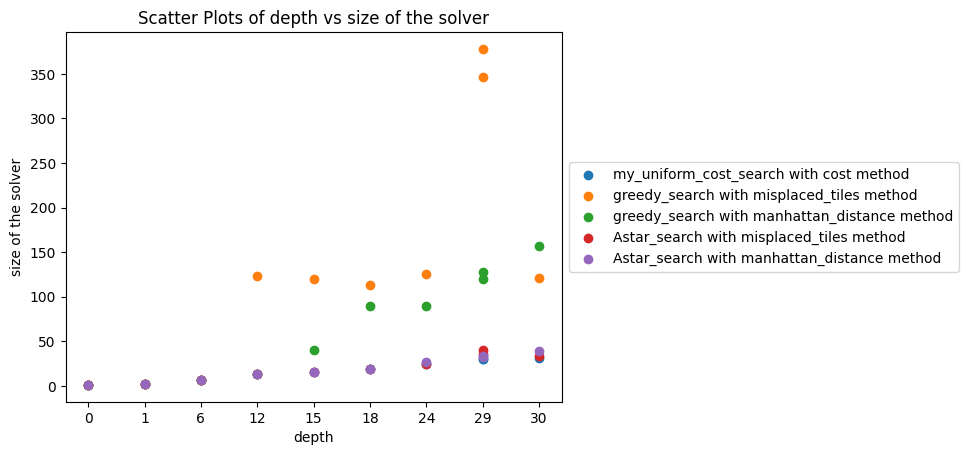

In [35]:
scatter_('depth', 'size of the solver')

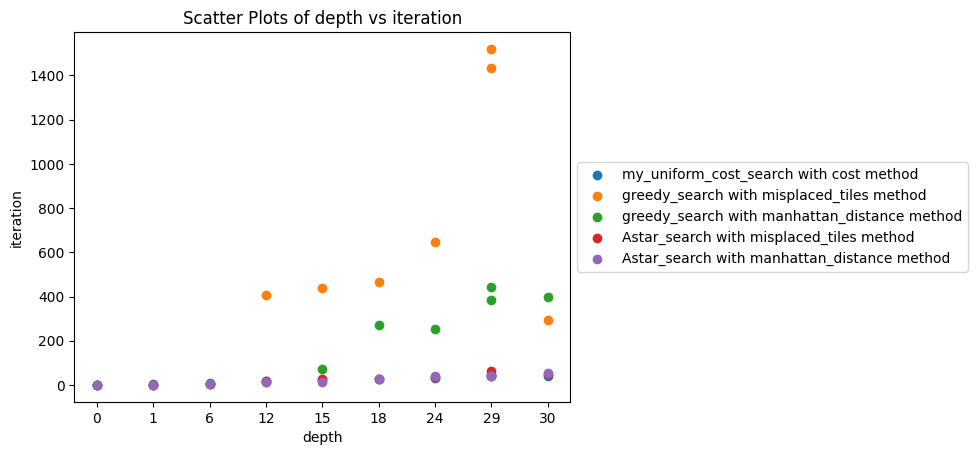

In [36]:
scatter_('depth', 'iteration')

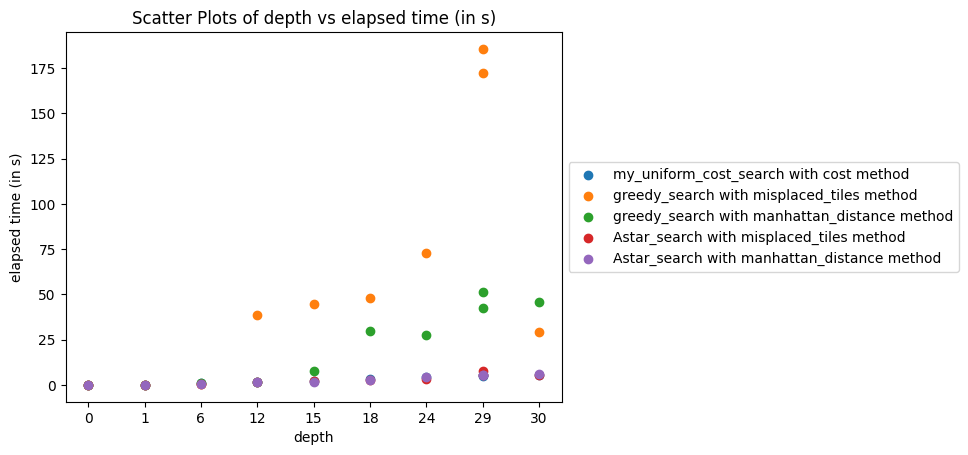

In [37]:
scatter_('depth', 'elapsed time (in s)')

## B. Misplaced Tiles

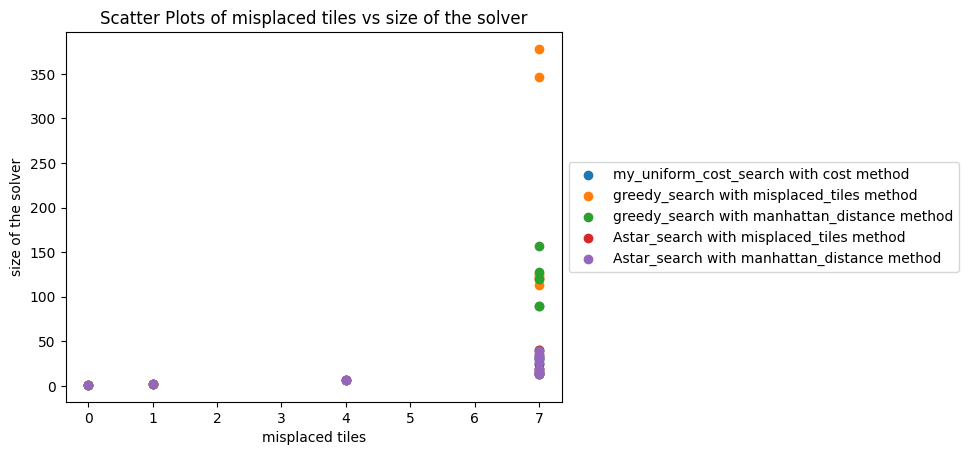

In [38]:
scatter_('misplaced tiles', 'size of the solver')

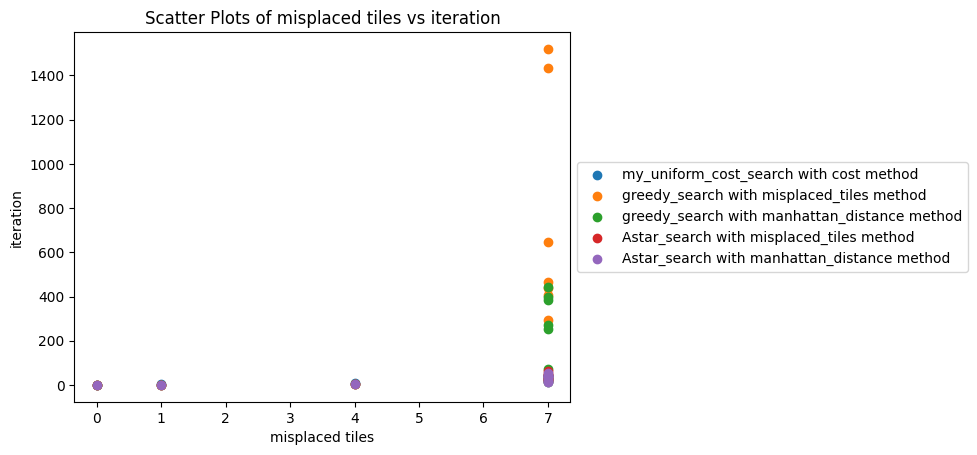

In [39]:
scatter_('misplaced tiles', 'iteration')

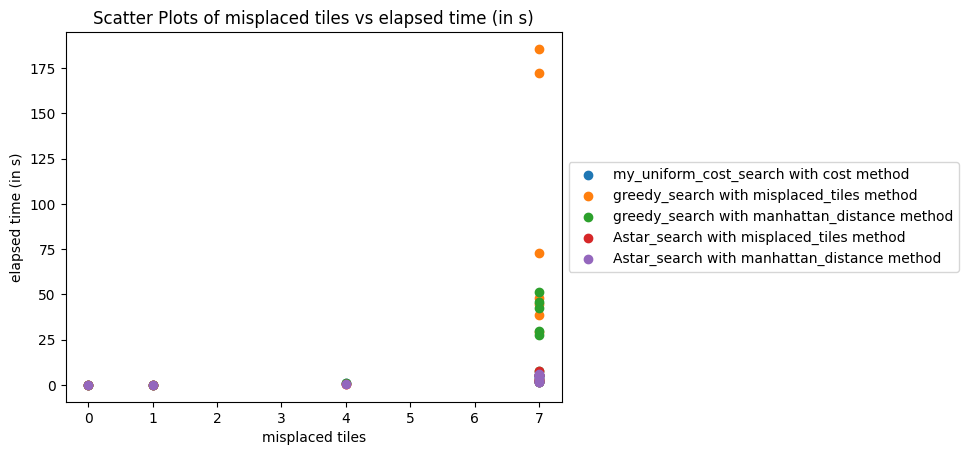

In [40]:
scatter_('misplaced tiles', 'elapsed time (in s)')

## C. Manhattan Distance

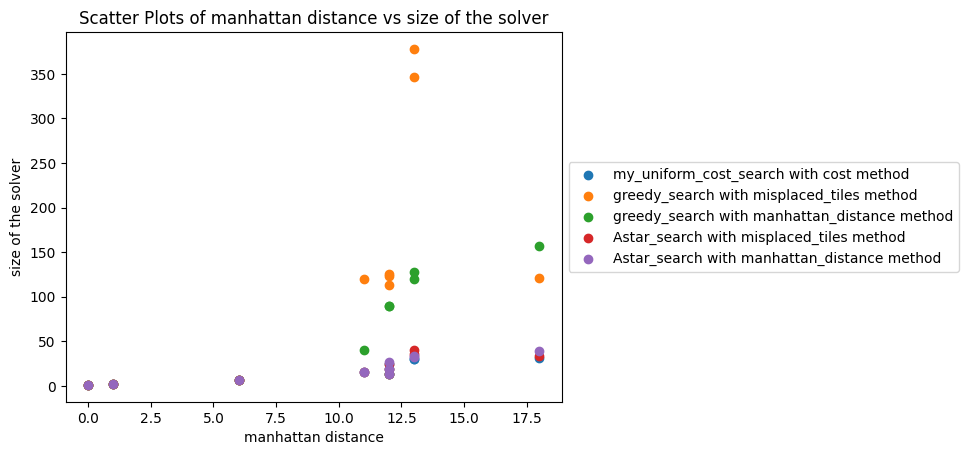

In [41]:
scatter_('manhattan distance', 'size of the solver')

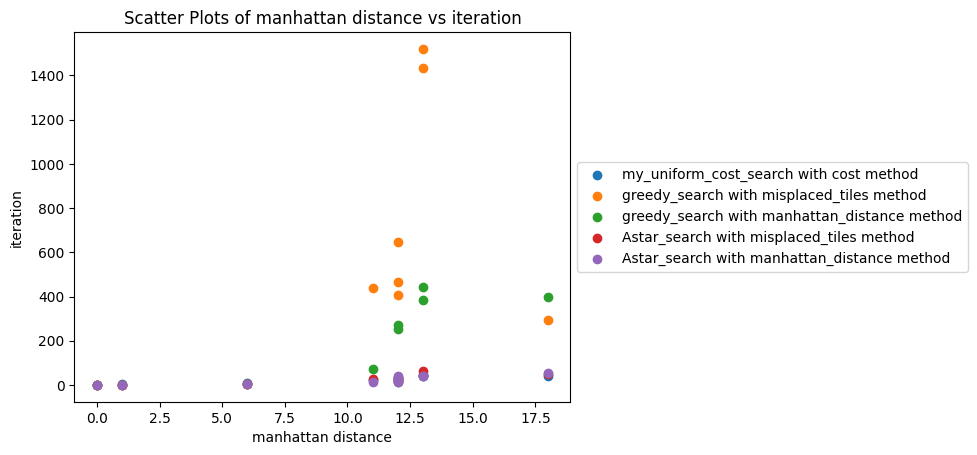

In [42]:
scatter_('manhattan distance', 'iteration')

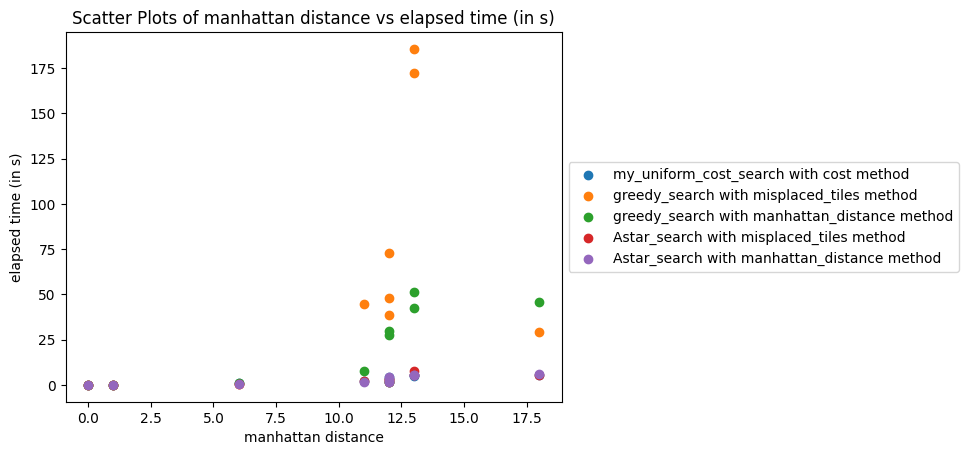

In [43]:
scatter_('manhattan distance', 'elapsed time (in s)')

# Conclusion
My method is the better method but it needs to load all the tree in a first time which take 30 min so.
If we consider other method, A* start search wins but we also use depth from tree.ndjson like my method, so it is not objective.
But we can conclude that in genenral Manhattan Distance is a better way to reach the goal for greedy search and A* search.